In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.0+cu118'

In [3]:
# setup device agnostic code
device='cuda' if  torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# create some data using linear regression formula of y=weight*X+bias
weight=0.7
bias=0.3

# create range values
start=0
end=1
step=0.02

# create X & y (features & labels)
X=torch.arange(start,end,step).unsqueeze(dim=1)
y=weight*X+bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
# split the data
train_split=int(0.8*len(X))
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

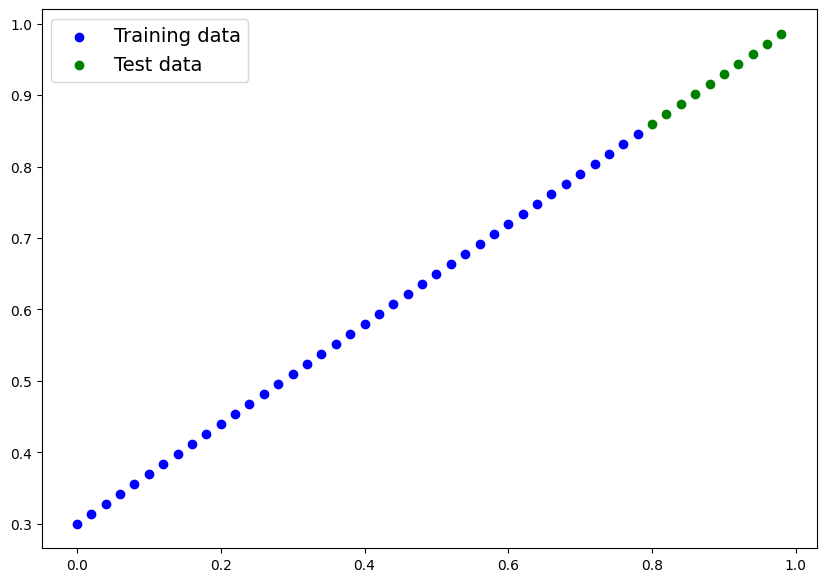

In [6]:
#plot the data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data,train_labels,c='b',label='Training data')
  plt.scatter(test_data,test_labels,c='g',label='Test data')
  if predictions is not None:
    plt.scatter(test_data,predictions,c='r',label='Predictions')
  plt.legend(prop={'size':14});

plot_predictions()

In [7]:
# create module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer=nn.Linear(in_features=1,
                                out_features=1)
  def forward(self,x:torch.Tensor)->torch.Tensor:
    return self.linear_layer(x)
#set model
torch.manual_seed(42) 
model_1=LinearRegressionModelV2()
model_1,model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [8]:
# check model current device
next(model_1.parameters()).device


device(type='cpu')

In [9]:
# set model to use target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [11]:
# set data to use target device
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

In [10]:
# setup loss function
loss_fn=nn.L1Loss()
# setup optimizer
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.01)


In [13]:
# training loop
torch.manual_seed(42)

epochs=200

for epoch in range(epochs):
  model_1.train()
  y_pred=model_1(X_train)
  loss=loss_fn(y_pred,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  ## testing
  model_1.eval()
  with torch.inference_mode():
    test_pred=model_1(X_test)
    test_loss=loss_fn(test_pred,y_test)
  #print what happening
  if epoch%10==0:
    print(f"Epoch: {epoch}|Loss:{loss}|Test loss:{test_loss}")  

Epoch: 0|Loss:0.5551779866218567|Test loss:0.5739762187004089
Epoch: 10|Loss:0.439968079328537|Test loss:0.4392664134502411
Epoch: 20|Loss:0.3247582018375397|Test loss:0.30455657839775085
Epoch: 30|Loss:0.20954833924770355|Test loss:0.16984669864177704
Epoch: 40|Loss:0.09433845430612564|Test loss:0.03513690456748009
Epoch: 50|Loss:0.023886388167738914|Test loss:0.04784907028079033
Epoch: 60|Loss:0.019956795498728752|Test loss:0.045803118497133255
Epoch: 70|Loss:0.016517987474799156|Test loss:0.037530567497015
Epoch: 80|Loss:0.013089174404740334|Test loss:0.02994490973651409
Epoch: 90|Loss:0.009653178043663502|Test loss:0.02167237363755703
Epoch: 100|Loss:0.006215683650225401|Test loss:0.014086711220443249
Epoch: 110|Loss:0.00278724217787385|Test loss:0.005814164876937866
Epoch: 120|Loss:0.0012645035749301314|Test loss:0.013801801018416882
Epoch: 130|Loss:0.0012645035749301314|Test loss:0.013801801018416882
Epoch: 140|Loss:0.0012645035749301314|Test loss:0.013801801018416882
Epoch: 150|

In [14]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [15]:
# making & evaluating predictions
model_1.eval()

with torch.inference_mode():
  y_preds=model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

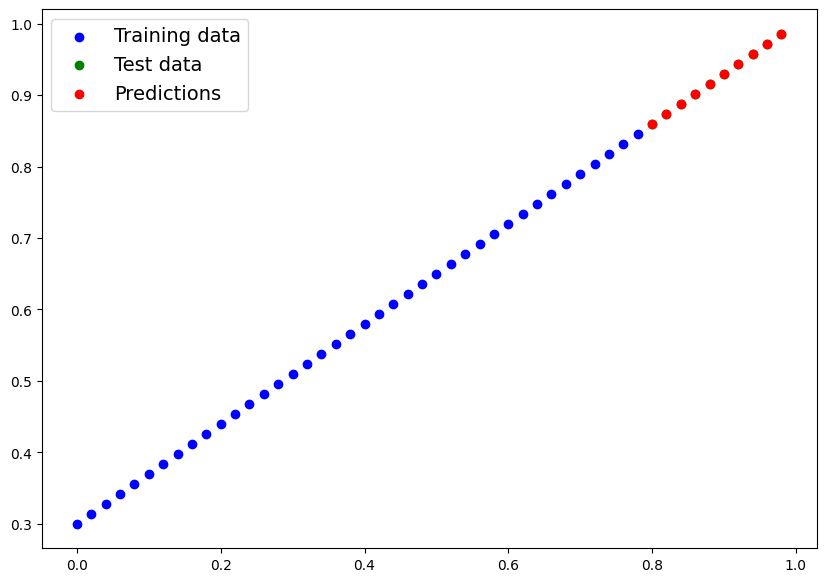

In [16]:
plot_predictions(predictions=y_preds.cpu())

In [17]:
# save & load trained model
from pathlib import Path

MODEL_PATH=Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME='01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH= MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

In [18]:
# load a model
loaded_model_1=LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [19]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [22]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds=loaded_model_1(X_test)
y_preds==loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')